# Imapartial - MONAI-Label API Demo
<img src="../images/impartial-logo.png" width="30%">

This demo shows the interactions with the ImPartial annotations API. This API **ties together image selection, inference, batch inference and result visualization** 

## Scenario
Assumes the following: 
1. Monailabel server is running on local host or an AWS instance.
2. Sample dataset has already been loaded into the server
3. Pre-trained model has been uploaded 

In [16]:
# Initialize dependencies, configurations and helper functions

import io
import requests
import numpy as np
import pickle

# MONAI Label is deployed locally on an EC2 instance:
monailabel_url = "http://localhost:8000"

# 1. Client Initialization

Information such as available models, training configuration and dataset stats can be retrieved from this endpoint.

`GET /info`


In [17]:
# Get Monai Label server info

res = requests.get(
    url=f"{monailabel_url}/info/"
)

res.raise_for_status()
res.json()

{'name': 'ImPartial',
 'description': 'Interactive deep-learning whole-cell segmentation and thresholding using partial annotations',
 'version': '2.0',
 'labels': ['Nuclei'],
 'models': {'impartial_1': {'type': 'segmentation',
   'labels': ['Nuclei'],
   'dimension': 2,
   'description': 'A pre-trained ImPartial segmentation model',
   'config': {'label_colors': {'Nuclei': [0, 255, 255]},
    'device': ['NVIDIA A10G']},
   'pathology': True},
  'impartial_2': {'type': 'segmentation',
   'labels': ['Nuclei'],
   'dimension': 2,
   'description': 'A pre-trained ImPartial segmentation model',
   'config': {'label_colors': {'Nuclei': [0, 255, 255]},
    'device': ['NVIDIA A10G']},
   'pathology': True},
  'impartial_3': {'type': 'segmentation',
   'labels': ['Nuclei'],
   'dimension': 2,
   'description': 'A pre-trained ImPartial segmentation model',
   'config': {'label_colors': {'Nuclei': [0, 255, 255]},
    'device': ['NVIDIA A10G']},
   'pathology': True}},
 'trainers': {'impartial_1'

# 2. Next Image Selection

In this step we use the active learning strategy to select an image from the unlabeled dataset. 
It could be random or it could be based on the entropy computed using the inference results.

`POST /activelearning/{strategy}`

that returns an image `id`.


In [18]:
# Select image from dataset using random strategy

res = requests.post(
    url=f"{monailabel_url}/activelearning/random"
)

res.raise_for_status()

image_id = res.json()["id"]

print(f"Selected '{image_id}'")

Selected 'image3'


# 3. Datastore - Get

Subsequently the image can be downloaded from the datastore using

`GET /datastore/image`

and passing the image `id` as parameter.

Displaying  'image0'
(2, 400, 400)


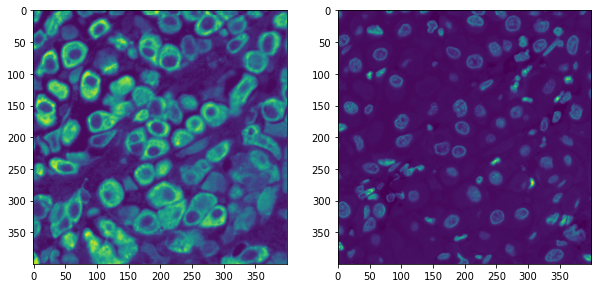

{'user': 'admin',
 'ts': 1744684129,
 'name': 'image0.tif',
 'path': '/home/ubuntu/Data/vectra2ch_pretrained/image0.tif'}

In [19]:
# Download image from datastore
import tifffile as tiff
import matplotlib.pyplot as plt 
image_id = "image0"

print(f"Displaying  '{image_id}'")

res = requests.get(
    url=f"{monailabel_url}/datastore/image",
    params={"image": image_id}
)

res.raise_for_status()

image = tiff.imread(io.BytesIO(res.content))

image = np.asarray(image)
print(image.shape)

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(image[0,:,:])

plt.subplot(1,2,2)
plt.imshow(image[1,:,:])

plt.show()


res = requests.get(
    url=f"{monailabel_url}/datastore/image/info",
    params={"image": image_id}
)

res.json()

# 4. Inference

Provide feedback to the user by running inference on the training image.

`POST /infer/impartial`

The results can also provide hints to the user where more scribbles are needed.


dict_keys(['output', 'entropy', 'metrics'])
(400, 400)
0.0 1.0


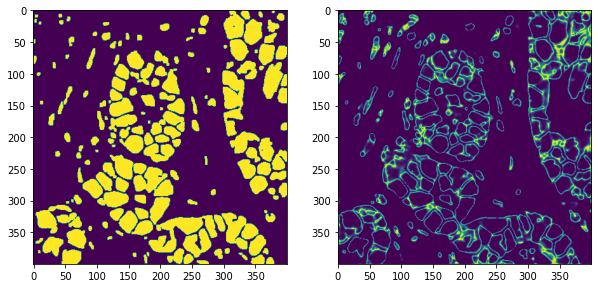

In [38]:
# Run Impartial inference

res = requests.post(
    f'{monailabel_url}/infer/impartial_2',
    params={"image": "image2", "output": "image"},
    # data={'params': '{"device": "cpu", "tile_size": [400, 400], "output": "default"}'}
)

res.raise_for_status()
output_json = res.json()
# print(res.contentjson_data = response.json() )

print(output_json.keys())
out = output_json['output']

import numpy as np 
import matplotlib.pyplot as plt
out = np.asarray(out)
print(out.shape)
print(out.min(), out.max())

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(out)

entropy = output_json["entropy"]
plt.subplot(1,2,2)
plt.imshow(entropy)

plt.show()

# 5. Batch Inference

`POST /batch/infer/impartial_2`

The results can also provide hints to the user where more scribbles are needed.


In [39]:
res = requests.post(
    f'{monailabel_url}/batch/infer/impartial_2',
)

res.raise_for_status()
output_json = res.json()

In [40]:
# Check batch inference status

res = requests.get(
    f'{monailabel_url}/batch/infer',
    # data={'params': '{"device": "cpu", "tile_size": [400, 400], "output": "default"}'}
)

res.raise_for_status()
res.json()

{'id': 'a358590a-00a6-4ee0-94ba-b0f4d2609c3f',
 'status': 'RUNNING',
 'request': {'model': 'impartial_2',
  'images': 'all',
  'device': 'cuda',
  'multi_gpu': True,
  'gpus': 'all',
  'logging': 'WARNING',
  'save_label': True,
  'label_tag': 'original',
  'max_workers': 1,
  'max_batch_size': 0},
 'start_ts': '2025-04-15 03:54:42',
 'details': ['[2025-04-15 03:54:42,330] [32463] [MainThread] [INFO] (__main__:37) - Initializing App from: /home/ubuntu/git-2025-03-24-merge-test/ImPartial/monailabel-app/api; studies: /home/ubuntu/Data/vectra2ch_pretrained; conf: {}']}

In [43]:
image_id = "image0"
res = requests.get(
    url=f"{monailabel_url}/datastore/label/info",
    params={"label": image_id, "tag": "original"}
)
print(res.json())

res = requests.get(
    url=f"{monailabel_url}/datastore/label/info",
    params={"label": image_id, "tag": "iter1"}
)
print(res.json())


{'model': 'impartial_2', 'params': {'label_names': ['Nuclei'], 'latencies': {'pre': 0.01, 'infer': 0.54, 'invert': 0.0, 'post': 0.0, 'write': 0.35, 'total': 0.9, 'transform': {'pre': {'LoadImaged': 0.0064, 'ToTensord': 0.0002, 'EnsureChannelFirstd': 0.0002}, 'post': {'GetImpartialOutputs': 0.0002, 'AggregateComponentOutputs': 0.0014, 'ComputeEntropy': 0.0025, 'ToNumpyd': 0.0002}}}, 'centroids': {}}, 'ts': 1744687993, 'name': 'image0.json'}
{'model': 'impartial_2', 'params': {'label_names': ['Nuclei'], 'latencies': {'pre': 0.01, 'infer': 2.25, 'invert': 0.0, 'post': 0.01, 'write': 0.33, 'total': 2.59, 'transform': {'pre': {'LoadImaged': 0.0071, 'ToTensord': 0.0003, 'EnsureChannelFirstd': 0.0002}, 'post': {'GetImpartialOutputs': 0.0002, 'AggregateComponentOutputs': 0.0009, 'ComputeEntropy': 0.0025, 'ToNumpyd': 0.0003}}}, 'centroids': {}}, 'ts': 1744684975, 'name': 'image0.json'}


dict_keys(['output', 'entropy', 'metrics'])


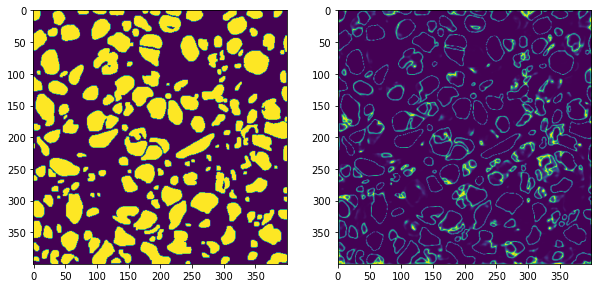

In [44]:
import numpy as np 
import matplotlib.pyplot as plt

image_id = "image0"
res = requests.get(
    url=f"{monailabel_url}/datastore/label",
    params={"label": image_id, "tag": "iter1"}
)
res = requests.get(
    url=f"{monailabel_url}/datastore/label",
    params={"label": image_id, "tag": "original"}
)

output_json = res.json()
print(output_json.keys())

out = output_json["output"]
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(out)

entropy = output_json["entropy"]
plt.subplot(1,2,2)
plt.imshow(entropy)

plt.show()
